# Avaliação de ISGD contínuo em holdouts - lastfm_50u

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import get_interactions_info, get_fixed_buckets_info, get_bucket_intervals, get_frequent_users, get_frequent_users_fixed_buckets
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [13]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
## Read Data

In [3]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/lastfm_50u.tsv","\t")
user_col = 'user_id'
item_col = 'item_id'

In [4]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data[user_col], data[item_col])

empty_stream = ImplicitData([], [])

In [5]:
# define hyperparameters
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

___
## Get intervals

In [9]:
# define frequency threshold
frequency_threshold = 0.8

time intervals

In [10]:
# Necessary Preprocess - create date from timestamp
data['date'] = data['timestamp'].apply(lambda x: datetime.strptime(x.split('T')[0], '%Y-%m-%d') )
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)
# get time intervals
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)
# get frequent users
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

7 users of 50 (14.0%) occurr in 80.0% or more months.
10 users of 50 (20.0%) occurr in 80.0% or more quarters.
14 users of 50 (28.0%) occurr in 80.0% or more semesters.


fixed bucket intervals

In [11]:
# define fixed bucket size
n_iter_bucket = 50E3

In [12]:
# get fixed bucket intervals
interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    
fixed_bucket_intervals=[(i,j) for i,j in zip(interval_start, interval_end)]
# get frequent users
user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end) # refactor this later
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

17 users of 50 (34.0%) occur in 80.0% or more buckets.


___
## Experiments using months

In [14]:
buckets, holdouts = getBucketsHoldouts(data=data, user_col=user_col, item_col=item_col, frequent_users=frequent_users_month, interval_type='M', intervals=None, cold_start_buckets=1)

### ISGD

In [15]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [16]:
# criamos instancia de EvaluateHoldouts para treinar modelos e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)
# 193 min

bucket 0
bucket 1
bucket 2
bucket 3
bucket 4
bucket 5
bucket 6
bucket 7
bucket 8
bucket 9
bucket 10
bucket 11
bucket 12
bucket 13
bucket 14
bucket 15
bucket 16
bucket 17
bucket 18
bucket 19
bucket 20
bucket 21
bucket 22
bucket 23
bucket 24
bucket 25
bucket 26
bucket 27
bucket 28
bucket 29
bucket 30
bucket 31
bucket 32


KeyboardInterrupt: 

In [ ]:
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

In [ ]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/lastfm/lastfm month_bucket ISGD results.csv', index=False)
# df = pd.read_csv('output/palco2010/palco_2010 month_bucket ISGD results.csv')

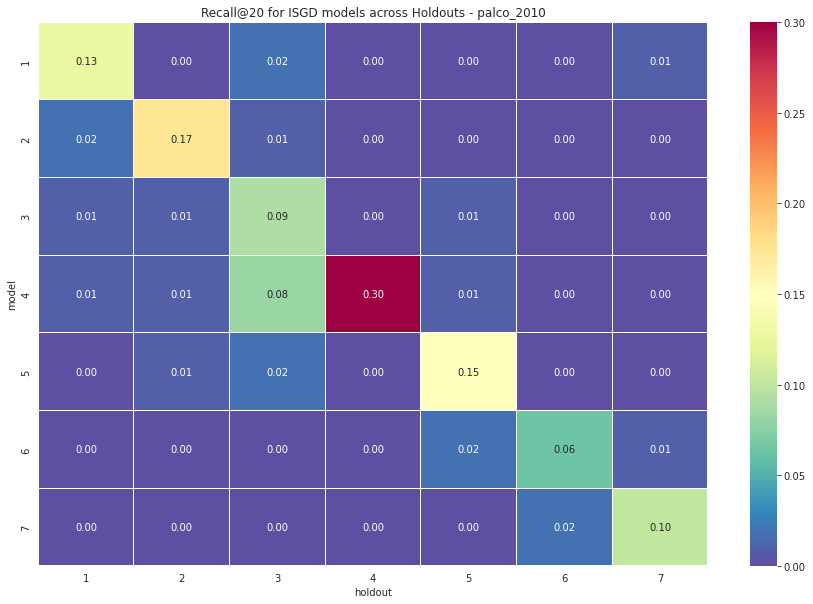

In [ ]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - lastfm',
    filepath='images/heatmaps/lastfm/lastfm month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [ ]:
arecall = avg_recall(df)
arecall

In [ ]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.11009174311926606,
  -0.14220183486238533,
  -0.09785932721712538,
  -0.16674311926605506,
  -0.16458715596330276,
  -0.14785932721712539],
 -0.13822375127421)

In [ ]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0030581039755351682

___
## Experiments using quarter

In [ ]:
buckets, holdouts = getBucketsHoldouts(data=data, user_col=user_col, item_col=item_col, frequent_users=frequent_users_trimestre, interval_type='QS', intervals=trimestres, cold_start_buckets=1)


### ISGD

In [ ]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
# criamos instancia de EvaluateHoldouts para treinar modelos e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)
# 17 min

bucket 0
bucket 1


In [ ]:
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

In [ ]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/lastfm/lastfm quarter_bucket ISGD results.csv', index=False)
# df = pd.read_csv('output/palco2010/palco_2010 month_bucket ISGD results.csv')

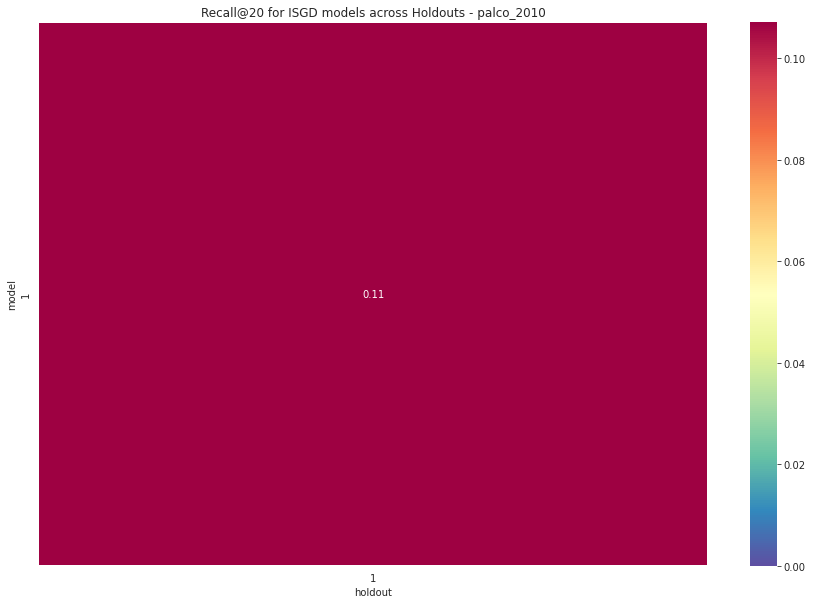

In [ ]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - lastfm',
    filepath='images/heatmaps/lastfm/lastfm quarter_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [ ]:
avg_recall(df)

In [ ]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.11009174311926606,
  -0.14220183486238533,
  -0.09785932721712538,
  -0.16674311926605506,
  -0.16458715596330276,
  -0.14785932721712539],
 -0.13822375127421)

In [ ]:
compute_FWT(df)
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0030581039755351682

___
## Experiments using semester


In [ ]:
buckets, holdouts = getBucketsHoldouts(data=data, user_col=user_col, item_col=item_col, frequent_users=frequent_users_semestre, interval_type='QS', intervals=semestres, cold_start_buckets=1)


### ISGD

In [ ]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
# criamos instancia de EvaluateHoldouts para treinar modelos e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)
# 17 min

bucket 0
bucket 1


In [ ]:
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

In [ ]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/lastfm/lastfm semester_bucket ISGD results.csv', index=False)
# df = pd.read_csv('output/palco2010/palco_2010 month_bucket ISGD results.csv')

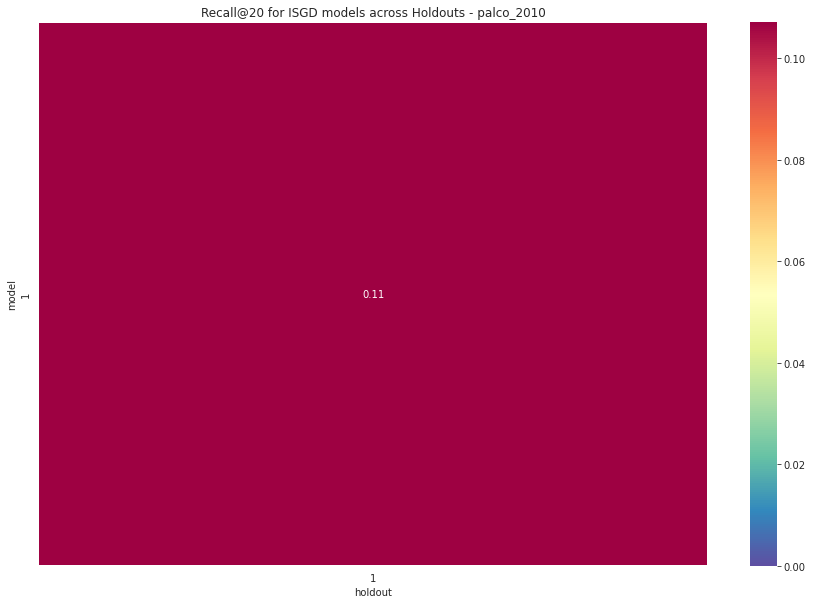

In [ ]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - lastfm',
    filepath='images/heatmaps/lastfm/lastfm semester_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

___
## Experiments using Fixed Bucket size


In [ ]:
buckets, holdouts = getBucketsHoldouts(data=data, user_col=user_col, item_col=item_col, frequent_users=frequent_users_bucket, interval_type='F', intervals=fixed_bucket_intervals, cold_start_buckets=1)

### ISGD

In [ ]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
# criamos instancia de EvaluateHoldouts para treinar modelos e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)
# 17 min

bucket 0
bucket 1
bucket 2
bucket 3
bucket 4
bucket 5
bucket 6
bucket 7
bucket 8
bucket 9
bucket 10
bucket 11


In [ ]:
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen
48201 user not seen
8393 user not seen
8324 user not seen
43850 user not seen
48649 user not seen


In [ ]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/lastfm/lastfm fixed_bucket ISGD results.csv', index=False)
# df = pd.read_csv('output/palco2010/palco_2010 month_bucket ISGD results.csv')

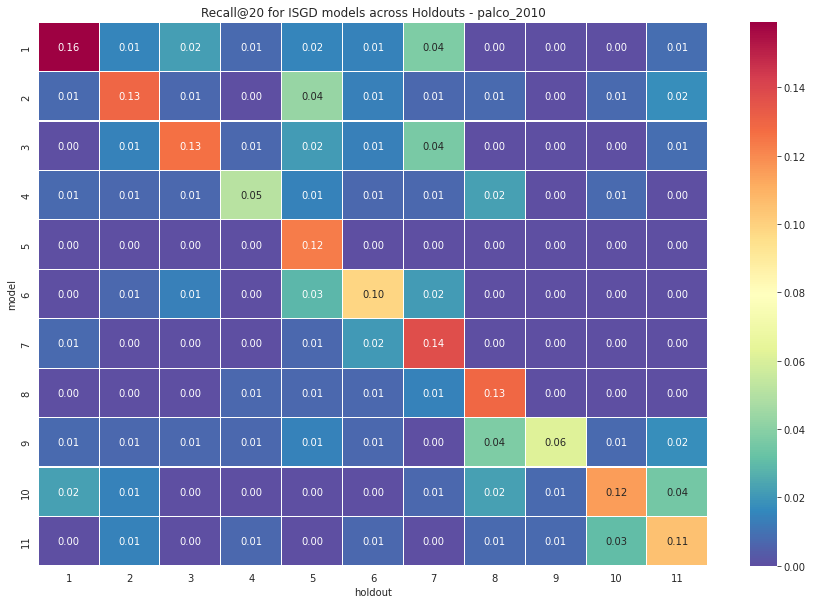

In [ ]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - lastfm',
    filepath='images/heatmaps/lastfm/lastfm fixed_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [ ]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.15151515151515152,
  -0.13709941137998694,
  -0.1311785398825626,
  -0.11670461589604568,
  -0.10794852209766745,
  -0.10877492062105447,
  -0.11287789328070982,
  -0.10831105812305662,
  -0.10469351236688085,
  -0.1057586965910097],
 -0.11848623217541257)

___

___
## old experiments

___
TREINO COM LASTFM_50u

In [5]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [6]:
eval = EvaluateAndStore(model=model,data=stream,n_holdouts=20,metrics = ["Recall@20"])

In [7]:
results=eval.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True)

A seguir calculamos uma matrix de resultados - todos os checkpoints de modelo avaliados em todos os holdouts.
Exclude known items está LIGADO.

In [8]:
# this took 5189 minutes with 20 holdouts - as per the heatmap, the number of holdouts used did not provide good insights
# mostly because of the sheer amount of data 
eval.EvaluateHoldouts(exclude_known_items=True)

In [9]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1)
df.to_csv('output/lastfm_50u results_matrix.csv', index=False)

In [4]:
# # Read results:
rm1 = pd.read_csv('output/lastfm_50u results_matrix.csv')

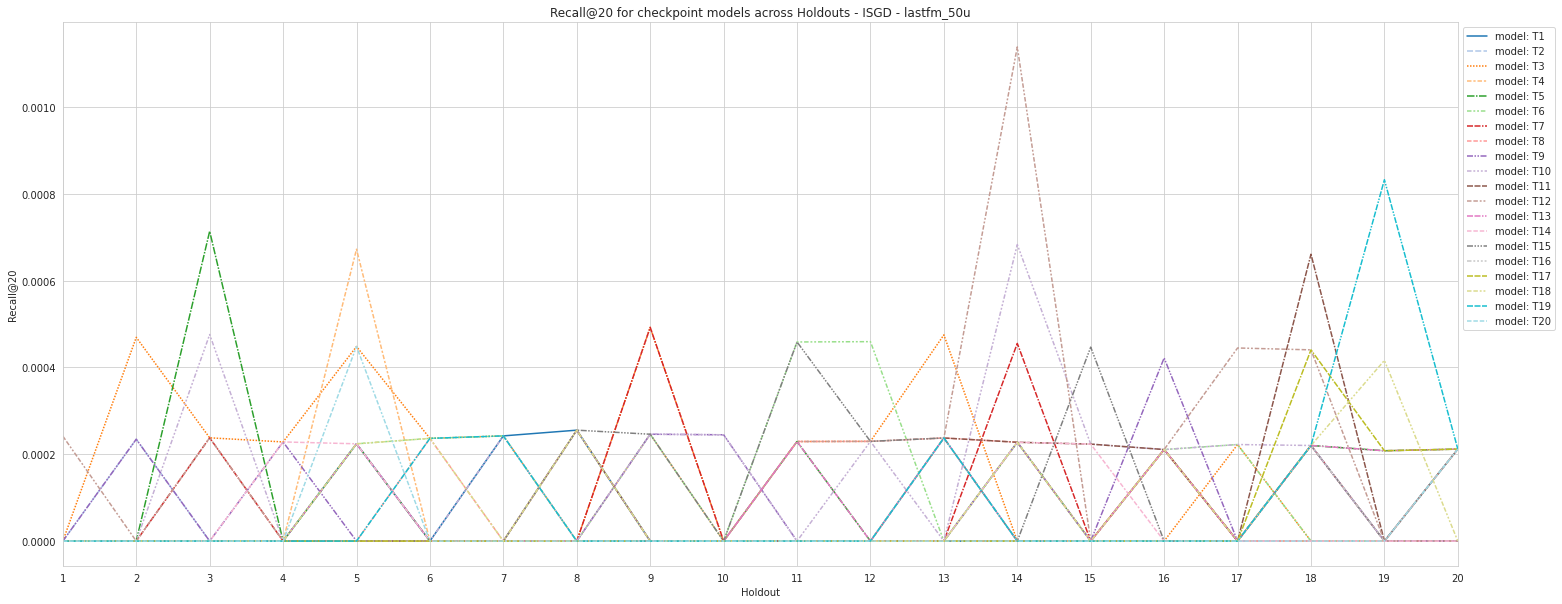

In [6]:
plt.figure(figsize=(25,10))
sns.lineplot(data=rm1, palette='tab20')
x_t = np.arange(0,20)
plt.xticks(x_t, labels=[str(i+1) for i in x_t])
plt.xlim(0, 19)
plt.xlabel('Holdout')
plt.ylabel('Recall@20')
plt.legend(bbox_to_anchor=(1.0,1), loc="upper left", labels=[f'model: T{model+1}' for model in range( rm1.shape[0] )])
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - lastfm_50u')
plt.savefig('images/previous experiments/lineplots/recall20 lineplot lastfm_50u');

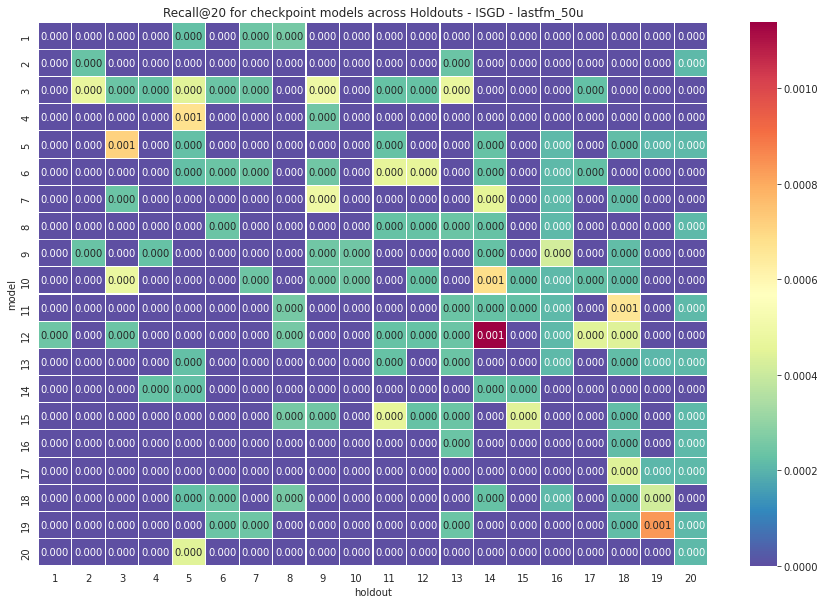

In [5]:
plt.figure(figsize=(15, 10))
x_t = np.arange(0,20)
labels=[str(i+1) for i in x_t]
sns.heatmap(rm1.T, vmin=0, vmax=rm1.max().max(), annot=True, fmt='0.3f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('model')
plt.xlabel('holdout')
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - lastfm_50u');
plt.savefig('images/previous experiments/heatmaps/recall20 heatmap lastfm_50u');

In [13]:
def matrix_euclidean_distance(p, q):
    return np.sqrt( np.sum( ( np.array(p) - np.array(q) )**2 ) )

user_factor_diff = np.zeros(shape=(20, 20))
item_factor_diff = np.zeros(shape=(20, 20))

for i in range( len( eval.model_checkpoints ) ):
    model_a = eval.model_checkpoints[i]
    for j in range( i, len( eval.model_checkpoints ) ):
        model_b = eval.model_checkpoints[j]

        user_factors_a = model_a.user_factors
        user_factors_b = model_b.user_factors
        item_factors_a = model_a.item_factors
        item_factors_b = model_b.item_factors

        user_len_dif = len(  user_factors_b ) - len(  user_factors_a )
        user_factors_a += [np.zeros(shape=(num_factors,)) for _ in range(user_len_dif)]
        item_len_dif = len(  item_factors_b ) - len(  item_factors_a )
        item_factors_a += [np.zeros(shape=(num_factors,)) for _ in range(item_len_dif)]

        user_factor_diff[i, j] = matrix_euclidean_distance(user_factors_a, user_factors_b)
        item_factor_diff[i, j] = matrix_euclidean_distance(item_factors_a, item_factors_b)

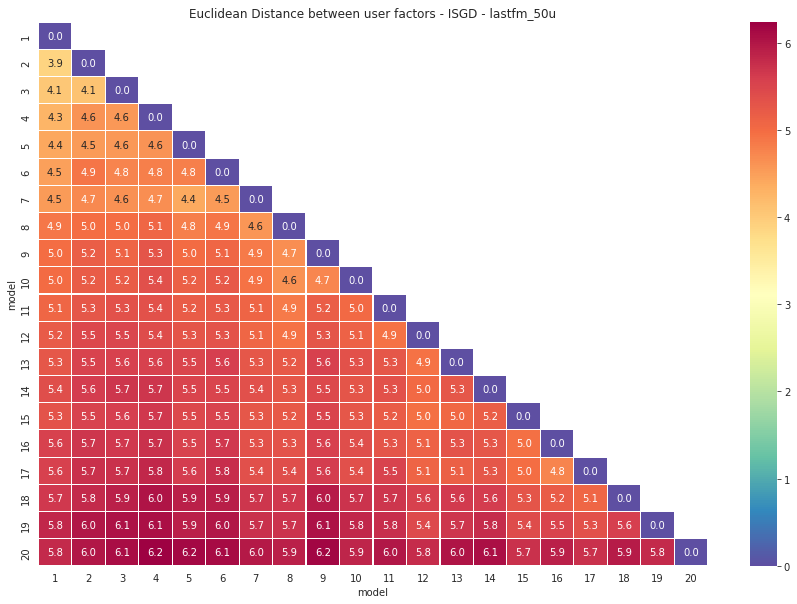

In [14]:
mask = np.zeros_like(user_factor_diff, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap( user_factor_diff.T, mask=mask, annot=True, fmt='0.1f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels) 
plt.ylabel('model')
plt.xlabel('model')
plt.title('Euclidean Distance between user factors - ISGD - lastfm_50u');
plt.savefig('output/ED user_factors heatmap lastfm_50u');

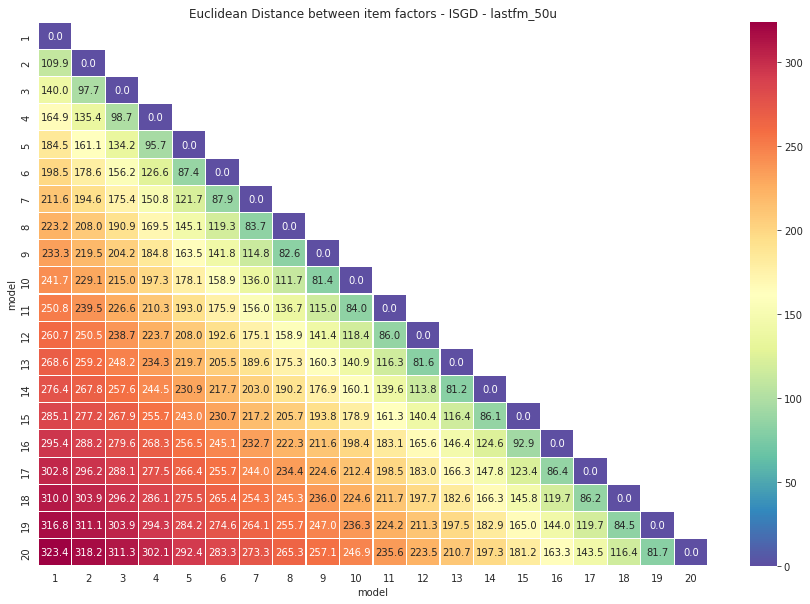

In [15]:
mask = np.zeros_like(user_factor_diff, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False
plt.figure(figsize=(15, 10))
sns.heatmap( item_factor_diff.T, mask=mask, annot=True, fmt='0.1f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels) 
plt.ylabel('model')
plt.xlabel('model')
plt.title('Euclidean Distance between item factors - ISGD - lastfm_50u');
plt.savefig('output/ED item_factors heatmap lastfm_50u');

___

### Shuffled Dataset

In [ ]:
shuffled_data = data.sample(frac=1).reset_index(drop=True).copy()

In [ ]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(shuffled_data['user_id'].to_list(), shuffled_data['track_id'].to_list())

empty_stream = ImplicitData([], [])

In [ ]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
eval = EvaluateAndStore(model=model,data=stream,n_holdouts=20,metrics = ["Recall@20"])

In [ ]:
results=eval.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True)

A seguir calculamos uma matrix de resultados - todos os checkpoints de modelo avaliados em todos os holdouts.
Exclude known items está LIGADO.

In [ ]:
eval.EvaluateHoldouts(exclude_known_items=True)

In [ ]:
rm1 = eval.results_matrix
df = pd.DataFrame(rm1)
df.to_csv('output/shuffled lastfm_50u results_matrix.csv', index=False)

In [ ]:
# # Read results:
# rm1 = pd.read_csv('output/shuffled palco_2010 results_matrix.csv')

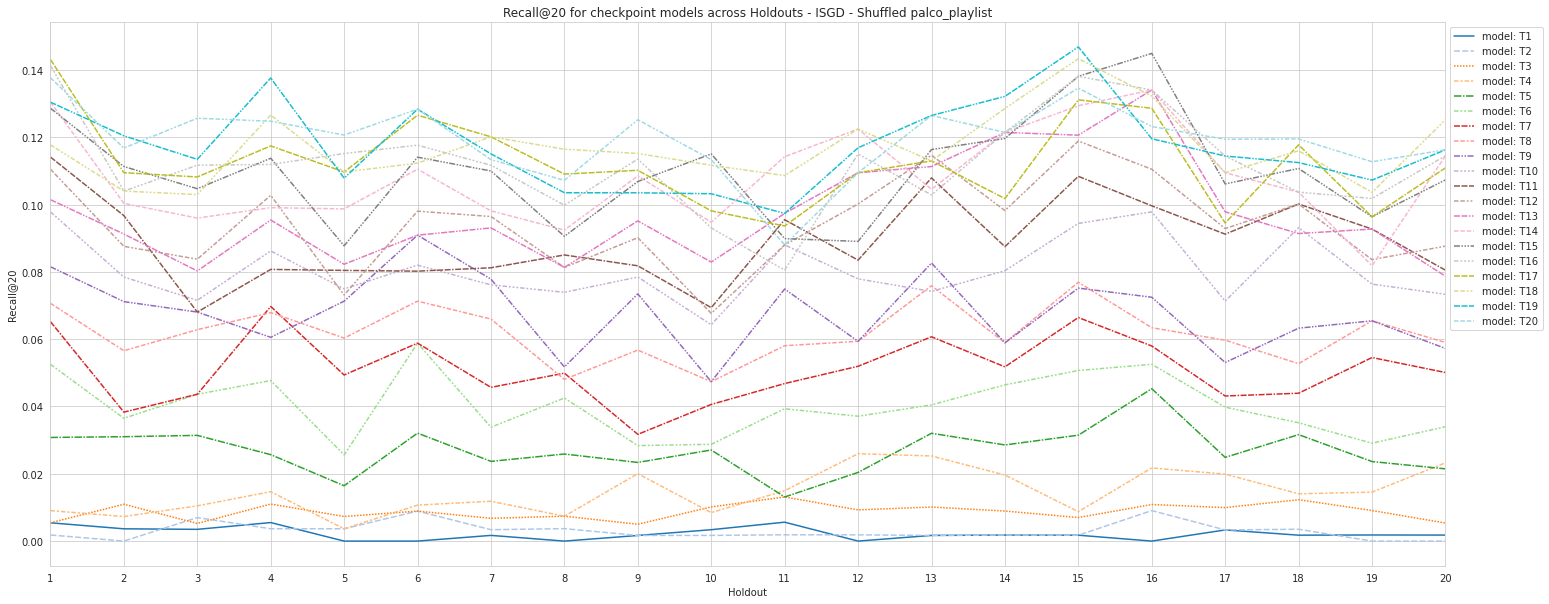

In [ ]:
plt.figure(figsize=(25,10))
sns.lineplot(data=rm1, palette='tab20')
x_t = np.arange(0,20)
plt.xticks(x_t, labels=[str(i+1) for i in x_t])
plt.xlim(0, 19)
plt.xlabel('Holdout')
plt.ylabel('Recall@20')
plt.legend(bbox_to_anchor=(1.0,1), loc="upper left", labels=[f'model: T{model+1}' for model in range( rm1.shape[0] )])
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - Shuffled lastfm_50u')
plt.savefig('output/recall20 lineplot shuffled lastfm_50u');

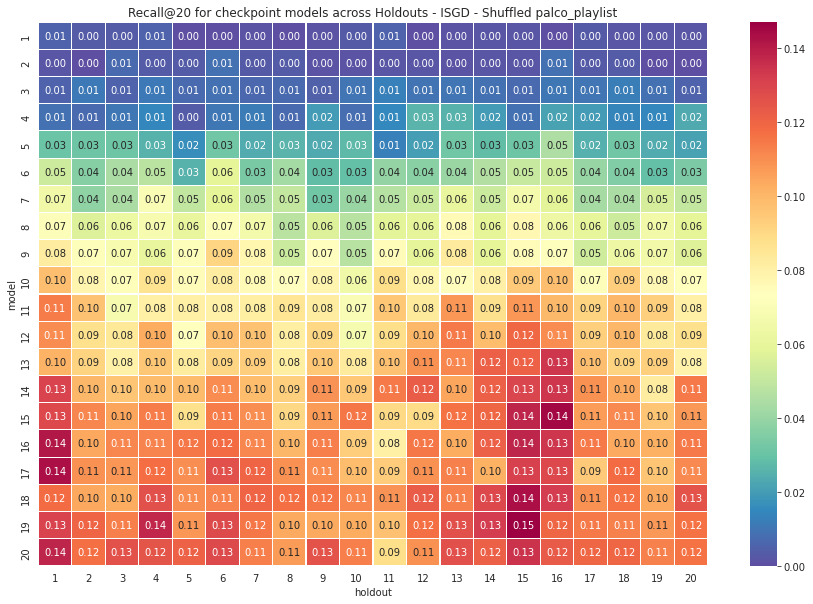

In [ ]:
plt.figure(figsize=(15, 10))
x_t = np.arange(0,20)
labels=[str(i+1) for i in x_t]
sns.heatmap(rm1.T, vmin=0, vmax=rm1.max().max(), annot=True, fmt='0.2f', linewidths=.1, cmap='Spectral_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('model')
plt.xlabel('holdout')
plt.title('Recall@20 for checkpoint models across Holdouts - ISGD - Shuffled lastfm_50u');
plt.savefig('output/recall20 heatmap shuffled lastfm_50u');